In [1]:
import sys
import os
from attrs import define, frozen, field
from functools import cached_property
from IPython.display import Image, SVG, display
current_dir = os.getcwd()
sys.path.append(current_dir[:-9])

In [2]:
current_dir

'/Users/sophieblock/torch_wf/notebooks'

In [3]:
from test.test_chemistry_network import test_construct_ref_circuit_network_BK


ModuleNotFoundError: No module named 'test.test_chemistry_network'

| Section | Outcome |
|---------|---------|
| 1 Classical scalars | Encode bits, signed/unsigned integers, fixed-point, IEEE-754 floats, strings |
| 2 Quantum scalars   | Model qubits, *n*-qubit integers, and fixed-point registers à la Qualtran |
| 3 Dyn & symbolics   | Represent unknown or symbolic widths \(n, m, \ldots\) and the sentinel **Dyn** |
| 4 Composites        | Build `TensorType` ($\mathbb R^{s_1\times\cdots\times s_r}$) and `CStruct` (records) |
| 5 Consistency engine| Use `check_dtypes_consistent` to check two dtypes compatible under ⟨global, C, Q⟩ ladders |
| 6 Resource formulas | Compute qubit/bit counts and memory footprints |

To do:
1. A collection of qubits must obey reversibility and no-cloning; encoding schemes (two’s-complement, fixed-point) must be unitary. The classical analogue `CInt`, `CUInt`, `CFxp`, `CFloat` impose no unitarity constraints; they may overflow or lose precision in place.
2. Classical bit is already implicit, but the qubit is the constrained resource driving algorithm design. `CBit` exists but storage-wise is rarely a limiting resource; we track it only for completeness.



## Why the current classical layer is not yet enough

| | Current support in `dtypes.py` | Gap |
|-----------------|---------------------------------|-----|
| **G-1** Precise modelling of scalar encodings (signed, unsigned, fxp, float, string) | ✔️ bit-width parametric classes (`CInt`, `CUInt`, `CFxp`, `CFloat`, `CString`) | no explicit *endianness*, no overflow / saturation policy, no distinction between storage-width and arithmetic-width |
| **G-2** Composite layouts for memory-centric cost models | ✔️ `TensorType` (n-D), `CStruct` (records) | no padding / alignment, no pointer / indirection, no cache-line notion |
| **G-3** Hierarchical resource formulas & architecture plug-ins | partly: every dtype now has `total_bits`, `nbytes` | missing: *access pattern* (sequential vs random), *parallelism factor*, CPU-cycle / energy tables |
| **G-4** Tight Q ⇄ C integration | checker handles `QBit⇄CBit` bridge, `RegisterSpec` tags `domain='Q'/'C'` | no *round-trip latency* model, no *measurement / classical-control* cost hooks |

Below is a **road-map** that keeps your existing design but makes it granular enough to hit G-1 ... G-4 without breaking the test-suite.


## 1. Richer scalar meta-data

```python
# ----------------------------------------------------------------
# Shared enums
# ----------------------------------------------------------------
class BitNumbering(Enum):
    MSB = "msb"          # bit-0 is most-significant (big-endian bit order)
    LSB = "lsb"          # bit-0 is least-significant (little-endian bit order)

class Endian(str, Enum):
    LITTLE = "little"
    BIG    = "big"        # ← Qualtran assumes big-endian qubits

class Overflow(str, Enum):
    WRAP   = "wrap"       # modulo 2^w        (current default)
    SAT    = "saturate"   # clamp to min/max
    ERROR  = "error"      # raise on overflow



---
### 1.1 Add to `CUInt` & `CInt`

```python
@frozen
class CUInt(CType):
    bit_width : SymbolicInt = 32
    endian    : Endian      = Endian.BIG
    overflow  : Overflow    = Overflow.WRAP
    …
```
Same for `CInt`. Update `to_bits` / `from_bits` to honour endian and check range according to overflow.
### 1.2 CFxp needs rounding mode

```python
class Rounding(str, Enum):
    TRUNC = "trunc"
    ROUND = "round_away0"
    STCH  = "stochastic"

@frozen
class CFxp(CType):
    bit_width : int
    num_frac  : int
    signed    : bool       = False
    rounding  : Rounding   = Rounding.TRUNC
    overflow  : Overflow   = Overflow.WRAP
```

## 2 Alignment-aware composites

### 2.1 Tensor layout descriptor
1. **Row Major Order:** In this format, the matrix is stored in row order, with each row stored before the next row in memory. I.e. row N comes before row N+1.
2. **Col Major Order:**  In this format, the matrix is stored in column-order, with each column stored before the next column in memory. I.e. column N comes before column N+1.

```python
@frozen
class TensorLayout(Enum):
    ROW_MAJOR = 0   # C   (inner-most stride = 1)
    COL_MAJOR = 1   # Fortran
    NHWC      = 2   # hardware accelerator typical


```
Classical accelerators (CUDA, TPU) pay a penalty when a tensor is not laid out in its preferred order; modelling the layout lets you map architecture-agnostic size → architecture-specific latency & energy.


### 2.2 Struct padding

Add optional field `align: int | None` to `CStruct`. Change `total_bits`:
```python
payload = 0
for ft in self.fields.values():
    payload = math.ceil(payload / self.align) * self.align if self.align else payload
    payload += getattr(ft,"total_bits",ft.data_width)
if self.align:
    payload = math.ceil(payload / self.align) * self.align
return payload

```
## 3 Cost-model plug-in interface

Create `workflow/simulation/refactor/cost_models.py`:

```python
class CostModel(abc.ABC):
    """Maps logical {total_bits, layout, …} → architecture metrics."""

    @abc.abstractmethod
    def classical_mem(self, nbytes:int, *, layout=None)->dict:
        """Return {'energy_pJ':…, 'latency_ns':…}"""

    @abc.abstractmethod
    def quantum_qubits(self, nqubits:int)->dict:
        """Return {'physical_qubits':…, 'surface_cycles':…}"""
```

## 1. Classical Scalar Types

#### 1.1 **Primitive bit and integers**: `CBit`, `CInt`, `CUInt`, `CFloat`

In [3]:
from workflow.simulation.refactor.dtypes import CBit, CInt, CFloat, CUInt
cbit  = CBit()
cint8 = CInt(8)
cint64 = CInt(16)
cuint32 = CUInt(32)
cuint64 = CUInt(64)

for dt in (cbit, cint8, cint64, cuint32,cuint64):
    print(f"{dt:<10}  width = {dt.data_width} bits, nbytes={dt.nbytes}")

CBit()      width = 1 bits, nbytes=1
CInt(8)     width = 8 bits, nbytes=1
CInt(16)    width = 16 bits, nbytes=2
CUInt(32)   width = 32 bits, nbytes=4
CUInt(64)   width = 64 bits, nbytes=8


#### 1.2 **Fixed-point, IEEE float, strings**

In [4]:
# print(f'CScalar Types - \n')
from workflow.simulation.refactor.dtypes import CFxp, CString
fxp64  = CFxp(16, 8)     # 16-bit fixed point, 8 frac bits
flt32  = CFloat(32)
string = CString(4)

for c in (fxp64, flt32, string):
    print(f"{c:15}  width={c.data_width} bits  nbytes={c.nbytes}")



CFxp(16, 8)      width=16 bits  nbytes=2
CFloat(32)       width=32 bits  nbytes=4
CString(32)      width=32 bits  nbytes=4


In [8]:

from workflow.simulation.refactor.dtypes import TensorType, MatrixType, CStruct

vec2   = TensorType((2,), element_type=CFloat(32))
mat34  = TensorType((3,4), element_type=CInt(16))
tensor34  = TensorType((3,4,5), element_type=CInt(16))
record = CStruct(fields={"id": CUInt(16), "flag": CBit()})

for dt in (vec2, mat34,tensor34, record):
    print(f"{dt:25}  width={dt.data_width},  nbytes= {dt.nbytes}, total_bits={dt.total_bits} ")


TensorType(2,)             width=32,  nbytes= 8, total_bits=64 
TensorType(3, 4)           width=16,  nbytes= 24, total_bits=192 
TensorType(3, 4, 5)        width=16,  nbytes= 120, total_bits=960 
CStruct(17)                width=17,  nbytes= 3, total_bits=17 


* `QBit()`  one logical qubit  
* `QInt(w)`  ($w≥1$) signed integer in two’s-complement  
* `QUInt(w)` unsigned integer in $[0,2^w\!-\!1]$

### Bit-roundtrip 

In [5]:
def roundtrip(dtype, samples):
    for x in samples:
        assert dtype.from_bits(dtype.to_bits(x)) == x
    print("✔", dtype)

roundtrip(CInt(4),  list(range(-8,8)))
roundtrip(CUInt(4), list(range(16)))
roundtrip(QInt(4),  list(range(-8,8)))

✔ CInt(4)
✔ CUInt(4)
✔ QInt(4)


#### `check_dtypes_consistent()` — global severities
Three global rungs:

| Global `DTypeCheckingSeverity` | Classical `C_PromoLevel` | Quantum  `Q_PromoLevel` |
|----------|-------------------|-----------------|
| `STRICT` | `STRICT`: | `STRICT`: Require exact dtype match, (same class, same num qubits) |
| `ANY`    | `PROMOTE`:           | `ANY`: allow single-qbit or `QAny` conversions if dimensions match |
| `LOOSE`  | `CAST`:               | `LOOSE`: Allow a broad range of QType conversions between, i.e., `QInt` <-> `QFxp`|

In [10]:
from workflow.simulation.refactor.dtypes import DTypeCheckingSeverity,C_PromoLevel, check_dtypes_consistent
pairs = [
    (CInt(8),  CInt(8)),
    (CInt(8),  CFloat(8)),
    (CInt(8),  CUInt(8)),
    (QInt(4),  QUInt(4)),
]
for a,b in pairs:
    print(f"{a:10}  vs  {b:10}  →",
          [check_dtypes_consistent(a,b,s) for s in DTypeCheckingSeverity])

CInt(8)     vs  CInt(8)     → [True, True, True]
CInt(8)     vs  CFloat(8)   → [False, True, True]
CInt(8)     vs  CUInt(8)    → [False, False, True]
QInt(4)     vs  QUInt(4)    → [False, False, True]


In [20]:
dtype_a = CUInt(8)
dtype_b = CFxp(8,0)

for clvl in C_PromoLevel:
    res = check_dtypes_consistent(
            dtype_a, dtype_b,
            classical_level=clvl
        )
    print(f"{clvl} --> {res}")
# print(f"C_PromoLevel.STRICT: {dtype_a} to {dtype_b} --> {res_strict}")

C_PromoLevel.STRICT --> False
C_PromoLevel.PROMOTE --> False
C_PromoLevel.CAST --> True



## 3. Dyn & symbolics
`Dyn` behaves like an existential variable **∃ w · w ∈ ℕ**,  
but **compares equal to itself** and never participates in arithmetic.
Formally, for any width $w\in\mathbb N\$

\begin{equation}
w = \mathcal D \;\lor\; \mathcal D = w \quad\Longrightarrow\quad
\text{“width matches” in consistency tests}.
\end{equation}

In the global ladder (STRICT, ANY, LOOSE) we treat

* `Dyn` ↔ concrete width: **False** under `STRICT`, **True** otherwise  
  (matches unit-test `test_symbolic_int_cases`).

In [22]:
import sympy
from workflow.simulation.refactor.dtypes import Dyn

n = sympy.symbols("n", positive=True, integer=True)
sym_ci = CInt(n)
other  = CInt("n")
dyn_ci = CInt(Dyn)

print("symbolic equal? ->", check_dtypes_consistent(sym_ci, other, DTypeCheckingSeverity.ANY))
print("Dyn vs concrete ANY ->",
      check_dtypes_consistent(dyn_ci, CInt(8), DTypeCheckingSeverity.ANY))

symbolic equal? -> True
Dyn vs concrete ANY -> True


In [36]:
t1 = TensorType((2,3), element_type=CInt(8))

t2= TensorType((2,3), element_type=CInt(Dyn))
t3 = TensorType((Dyn,3), element_type=CInt(8))
print("Matrix == Tensor same shape?",
      check_dtypes_consistent(t1,t2,DTypeCheckingSeverity.STRICT))


for clvl in C_PromoLevel:
    print(f'{clvl}:')
    res = check_dtypes_consistent(
            t1, t2,
            classical_level=clvl
        )
    print(f"{repr(t1)} & {repr(t2)} --> {res}")
    res = check_dtypes_consistent(
            t1, t3,
            classical_level=clvl
        )
    print(f"{repr(t1)} & {repr(t3)} --> {res}")
    res = check_dtypes_consistent(
            t2, t3,
            classical_level=clvl
        )
    print(f"{repr(t2)} & {repr(t3)} --> {res}\n")

Matrix == Tensor same shape? False
C_PromoLevel.STRICT:
TensorType((2, 3), dtype=CInt(8)) & TensorType((2, 3), dtype=CInt(Dyn)) --> True
TensorType((2, 3), dtype=CInt(8)) & TensorType((Dyn, 3), dtype=CInt(8)) --> True
TensorType((2, 3), dtype=CInt(Dyn)) & TensorType((Dyn, 3), dtype=CInt(8)) --> True

C_PromoLevel.PROMOTE:
TensorType((2, 3), dtype=CInt(8)) & TensorType((2, 3), dtype=CInt(Dyn)) --> True
TensorType((2, 3), dtype=CInt(8)) & TensorType((Dyn, 3), dtype=CInt(8)) --> True
TensorType((2, 3), dtype=CInt(Dyn)) & TensorType((Dyn, 3), dtype=CInt(8)) --> True

C_PromoLevel.CAST:
TensorType((2, 3), dtype=CInt(8)) & TensorType((2, 3), dtype=CInt(Dyn)) --> True
TensorType((2, 3), dtype=CInt(8)) & TensorType((Dyn, 3), dtype=CInt(8)) --> True
TensorType((2, 3), dtype=CInt(Dyn)) & TensorType((Dyn, 3), dtype=CInt(8)) --> True



### Resource Tracking

In [37]:
import torch
def bits_of(torch_tensor):
    return torch_tensor.nelement() * torch_tensor.element_size() * 8

torch_tensor = torch.ones((2,2,2), dtype=torch.int8)
dt = TensorType(torch_tensor.shape, element_type=torch.int8)
print("Torch bits:", bits_of(torch_tensor), "  vs  dtypes:", dt.total_bits)

Torch bits: 64   vs  dtypes: 64


In [8]:

from workflow.simulation.refactor.builder import ProcessBuilder
from workflow.simulation.refactor.register import Signature, RegisterSpec, Flow
q4  = QInt(4)
f64  = CFloat(64)
vec2   = TensorType((2,), element_type=CFloat(32))

rx = RegisterSpec("x", dtype=vec2,           flow=Flow.LEFT)
rq = RegisterSpec("psi", dtype=q4,           flow=Flow.LEFT)
ry = RegisterSpec("y", dtype=f64,     flow=Flow.RIGHT)

print(rx)
print(f"total_bits on wire: {rx.total_bits()}  (fan-out {rx.shape})")



InSpec(name=x, dtype=TensorType(2,), shape=())
total_bits on wire: 64  (fan-out ())


In [ ]:
from workflow.simulation.refactor.builder import Split

from workflow.visualization_tools import ModuleDrawer,display_mod
# from workflow.simulation.refactor.process import Process,ClassicalProcess

split = Split(CInt(4)).as_composite()

display_mod(split,  show_bookkeeping=False)

CInt(4), output dtype: CBit(), fan_out: 4 - builder.py - signature()


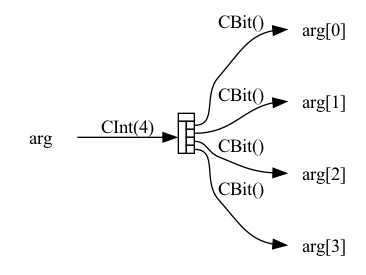

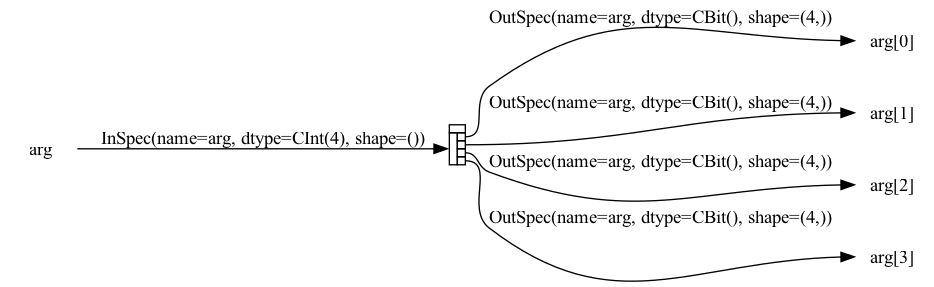

In [10]:
from workflow.simulation.refactor.builder import Split

split = Split(CInt(4)).as_composite()
display_mod(split,type='dtype',show_bookkeeping=False )

display_mod(split,type='shape',show_bookkeeping=False )


TensorType((2,), dtype=CInt(2)) with element dtype: CInt(2) output dtype: CInt(2), elem_width: 2, n_elems: 2, fan_out: 2 - builder.py - signature()
in_ports: {'arg': LeftDangle.V} - builder.py - add()
in_ports: {'arg': array([Split<0>.arg[0], Split<0>.arg[1]], dtype=object)} - builder.py - add()
Split<0>
  LeftDangle.V -> arg
  arg[0] -> Join<1>.arg[0]
  arg[1] -> Join<1>.arg[1]
--------------------
Join<1>
  Split<0>.arg[0] -> arg[0]
  Split<0>.arg[1] -> arg[1]
  arg -> RightDangle.a_tensor


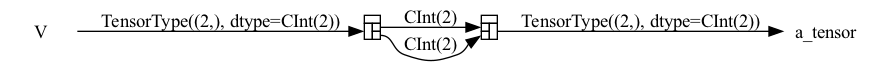

UnboundLocalError: cannot access local variable 'cxn_label' where it is not associated with a value

UnboundLocalError: cannot access local variable 'cxn_label' where it is not associated with a value

In [13]:
from workflow.simulation.refactor.dtypes import TensorType
from workflow.simulation.refactor.builder import Split, Join
builder = ProcessBuilder()
atomic_reg = RegisterSpec(name="V", dtype=TensorType((2,),element_type=CInt(2)), flow=Flow.LEFT)


in_port = builder.add_register(atomic_reg)  # returns a single Port
split_out= builder.add(Split(dtype=in_port.reg.dtype), arg=in_port)
join_process = Join(dtype=atomic_reg.dtype)
joined_out = builder.add(join_process, arg=split_out)
composite_mod = builder.finalize(a_tensor=joined_out)
print(composite_mod.debug_text())
display_mod(composite_mod,type='dtype',show_bookkeeping=False)
display_mod(composite_mod,type='shape',show_bookkeeping=False)


In [ ]:
composite_mod.print_tabular()

InSpec(name=arg, dtype=CInt(4), shape=())


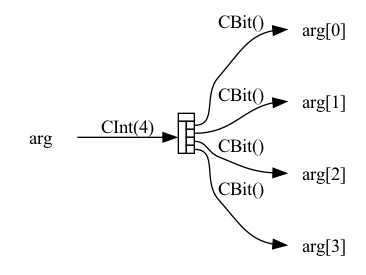

In [5]:
from workflow.simulation.refactor.builder import Split, Join
from workflow.simulation.refactor.dtypes import TensorType, CInt
split = Split(CInt(4)).as_composite()
drawer = ModuleDrawer(split, show_bookkeeping=False)
drawer


In [ ]:

builder = ProcessBuilder()
atomic_reg = RegisterSpec(name="a_tensor", dtype=TensorType((2,),element_type=int), flow=Flow.LEFT)